## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.8.0


### Get the dataset

In [3]:
training_dir = '../dataset/training'
validation_dir = '../dataset/validation'
test_dir = '../dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 10320 files belonging to 6 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset

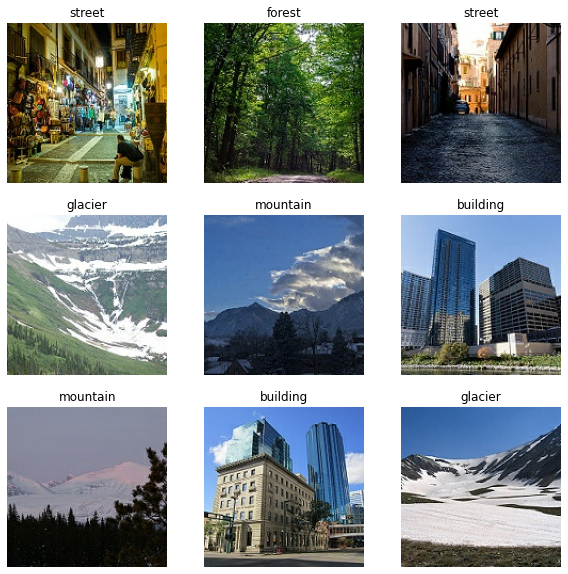

In [6]:
class_names = training_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

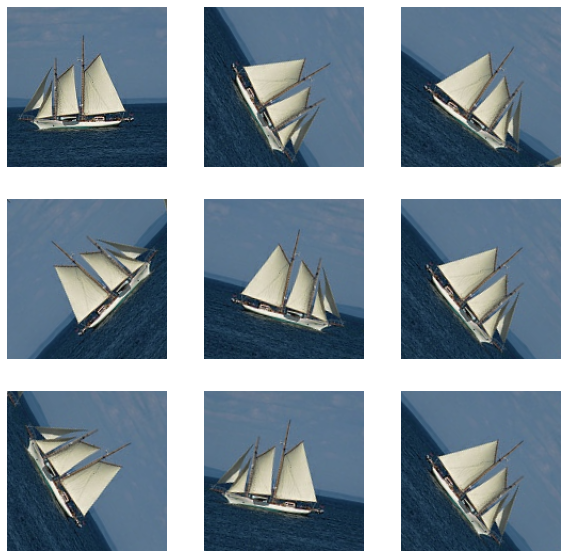

In [8]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model Development And Training

### Rescale pixel values

We will use `tf.keras.applications.DenseNet121` as our base model.

In [9]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

### Creation of the base model using a CNN architecture

In [10]:
# Create the base model from the pre-trained model DenseNet121
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

29097984/29084464 [==============================] - 4s 0us/step


In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 75, 75, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1/conv[0][0]']   

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 38, 38, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 38, 38, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 38, 38, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 38, 38, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 19, 19, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 19, 19, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 19, 19, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 19, 19, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 19, 19, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 19, 19, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 19, 19, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 19, 19, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 19, 19, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 9, 9, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 9, 9, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 9, 9, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 9, 9, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 9, 9, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 9, 9, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 9, 9, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 9, 9, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 9, 9, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 9, 9, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 9, 9, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 9, 9, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 9, 9, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 9, 9, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 9, 9, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 9, 9, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 9, 9, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 9, 9, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 9, 9, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 9, 9, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 9, 9, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 4, 4, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 4, 4, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 4, 4, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 4, 4, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 4, 4, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 4, 4, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 4, 4, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 4, 4, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 4, 4, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 4, 4, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [13]:
prediction_layer = tf.keras.layers.Dense(len(class_names))

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [14]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model (Feature extraction)

In [15]:
from tensorflow.keras.optimizers import Adam

base_learning_rate = 0.0001

opt = Adam(learning_rate=base_learning_rate)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = opt,
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        703750

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

81/81 [==============================] - 58s 692ms/step - loss: 2.6152 - accuracy: 0.1186
initial loss: 2.62
initial accuracy: 0.12


### Model training

In [18]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
323/323 [==============================] - 297s 907ms/step - loss: 1.5956 - accuracy: 0.4218 - val_loss: 1.0084 - val_accuracy: 0.6453
Epoch 2/10
323/323 [==============================] - 299s 926ms/step - loss: 0.8889 - accuracy: 0.6755 - val_loss: 0.6412 - val_accuracy: 0.7841
Epoch 3/10
323/323 [==============================] - 296s 918ms/step - loss: 0.6731 - accuracy: 0.7533 - val_loss: 0.5030 - val_accuracy: 0.8353
Epoch 4/10
323/323 [==============================] - 287s 888ms/step - loss: 0.5720 - accuracy: 0.7924 - val_loss: 0.4334 - val_accuracy: 0.8597
Epoch 5/10
323/323 [==============================] - 291s 900ms/step - loss: 0.5272 - accuracy: 0.8078 - val_loss: 0.3935 - val_accuracy: 0.8721
Epoch 6/10
323/323 [==============================] - 291s 901ms/step - loss: 0.4854 - accuracy: 0.8233 - val_loss: 0.3644 - val_accuracy: 0.8771
Epoch 7/10
323/323 [==============================] - 291s 900ms/step - loss: 0.4572 - accuracy: 0.8362 - val_loss: 0.3424 -

In [19]:
base_model.trainable = True

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Recompile the model (Fine tuning)

In [20]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 150, 150, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 4, 4, 1024)        703750

### Continue training and save the model

In [22]:
fine_tuning_epochs = 10

total_epochs =  initial_epochs + fine_tuning_epochs

history = model.fit(training_dataset,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=validation_dataset)

Epoch 10/20
323/323 [==============================] - 640s 2s/step - loss: 0.3416 - accuracy: 0.8804 - val_loss: 0.2504 - val_accuracy: 0.9120
Epoch 11/20
323/323 [==============================] - 652s 2s/step - loss: 0.2757 - accuracy: 0.8987 - val_loss: 0.2420 - val_accuracy: 0.9202
Epoch 12/20
323/323 [==============================] - 644s 2s/step - loss: 0.2448 - accuracy: 0.9147 - val_loss: 0.2268 - val_accuracy: 0.9240
Epoch 13/20
323/323 [==============================] - 671s 2s/step - loss: 0.2246 - accuracy: 0.9211 - val_loss: 0.2346 - val_accuracy: 0.9143
Epoch 14/20
323/323 [==============================] - 679s 2s/step - loss: 0.2134 - accuracy: 0.9272 - val_loss: 0.2144 - val_accuracy: 0.9233
Epoch 15/20
323/323 [==============================] - 655s 2s/step - loss: 0.1988 - accuracy: 0.9313 - val_loss: 0.2056 - val_accuracy: 0.9260
Epoch 16/20
323/323 [==============================] - 666s 2s/step - loss: 0.1895 - accuracy: 0.9333 - val_loss: 0.2288 - val_accuracy:

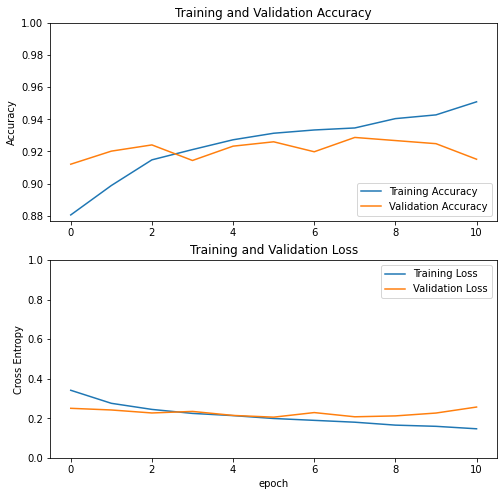

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save the model

In [24]:
import os

os.mkdir('../SavedModel/')

model.save('../SavedModel/')

INFO:tensorflow:Assets written to: ../SavedModel/assets
